# Gravitational wave detection with neural networks

In [Gabbard et al](https://journals.aps.org/prl/abstract/10.1103/PhysRevLett.120.141103) convolutional neural networks are used to detect simulated signals from binary black hole coalescence in noisy data. This notebook outlines the approached used with a snippet of the data used in the publication.

A convolutional neural network will used to detect the signals and its performance analysed.

[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mj-will/intro2ml/blob/master/notebooks/gravitational-wave-detection.ipynb)

In [19]:
import os
from six.moves import cPickle as pickle
import numpy as np
import matplotlib.pyplot as plt
plt.style.use('ggplot')

import tensorflow.keras as keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.optimizers import Adam

keras.backend.set_image_data_format('channels_first')

## Data

Data is available [here](http://www.astro.gla.ac.uk/users/michael/datasets/bbh/BBH_training_1s_1024Hz_10Ksamp_1n_iSNR8_Hdet_astromass_1seed_ts_0.pkl) but this notebook will automatically download it with the following function.

In [2]:
def fetch_data(url, filename):
    import urllib
    urllib.request.urlretrieve(url, filename=filename)

In [3]:
data_url = 'http://www.astro.gla.ac.uk/users/michael/datasets/bbh/BBH_training_1s_1024Hz_10Ksamp_1n_iSNR8_Hdet_astromass_1seed_ts_0.pkl'
data_file = './data.pkl'
if not os.path.isfile(data_file):
    fetch_data(data_url, data_file)

In [4]:
def load_data(data_file, start=512, length=1024):
    """Load the data and remove the first and last 0.5 seconds of padding"""
    with open(data_file, 'rb') as f:
        x, y = pickle.load(f)
    # ts are 16384 long, so want middle 8192 samples
    x = x[:,:,start:(start+length)]
    print(f'x shape: {x.shape}, y shape: {y.shape}')
    # reshape for 2D convolutions
    x = np.expand_dims(x, axis=2)
    print(f'x shape: {x.shape}, y shape: {y.shape}')
    return x, y

In [5]:
x, y = load_data(data_file)

x shape: (10000, 1, 1024), y shape: (10000,)
x shape: (10000, 1, 1, 1024), y shape: (10000,)


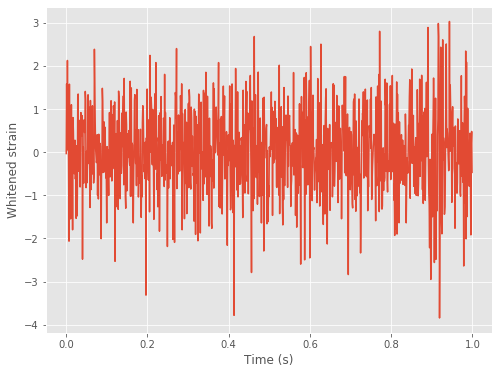

In [6]:
fs = 1024                       # sampling frequency
t = np.arange(0, 1, 1. / fs)
fig = plt.figure(figsize=(8,6))
plt.plot(t, x[0, 0, 0])
plt.xlabel("Time (s)")
plt.ylabel("Whitened strain")
plt.show()

### Labels

In their original forms the labels are simply a list of zeros and ones:

In [7]:
print(f'Label vector: {y[:10]}')

Label vector: [1 0 1 1 0 0 1 0 0 1]


Because of the loss function we're going to use this needs to be converted to a matrix form:

In [8]:
num_classes = 2
y_cat = keras.utils.to_categorical(y, num_classes)
print(f'Label matrices: {y_cat[:10]}')

Label matrices: [[0. 1.]
 [1. 0.]
 [0. 1.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]
 [1. 0.]
 [1. 0.]
 [0. 1.]]


Where the first column now corresponds to noise and the second to signal. So `[1. 0.]` indicates noise and `[0. 1.]` indicates a signal.

### Training/testing split

We reserve some of the data to use after training. This is used to test the network peformance on unseen data.

In [9]:
n_train = int(0.9 * x.shape[0])
x_train, x_test = x[:n_train], x[n_train:]
y_train, y_test = y_cat[:n_train], y_cat[n_train:]

## The model

The model define the structure of the neural network we're going to train.

In this case we're going to use a mix of convolutional layers and fully connected layers.

In [10]:
batch_size = 50              # number of samples in each batch of training data
input_shape = [1, 1, 1024]   # shape of the data
activation = 'relu'

In [11]:
model = Sequential()
model.add(Conv2D(16, 
                 kernel_size=(1, 16), 
                 input_shape=input_shape, 
                 activation=activation))
model.add(MaxPooling2D(pool_size=(1, 4)))
model.add(Conv2D(16, 
                 kernel_size=(1, 16), 
                 activation=activation))
model.add(MaxPooling2D(pool_size=(1, 4)))
model.add(Flatten())
model.add(Dense(32, activation=activation))
model.add(Dense(2, activation='softmax'))
print(model.summary())

Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor
Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 16, 1, 1009)       272       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 16, 1, 252)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 16, 1, 237)        4112      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 16, 1, 59)         0         
_________________________________________________________________
flatten (Flatten)            (None, 944)               0         
_________________________________________________________________
dense (Dense)                (None, 32)                30240     
____

### Compiling

In keras the model must be compiled before training. It's at this stage that we specify the loss function to use and what optimiser to use.

The optimiser is the algorithm that is used to explore the parameter space of the network weights.

In this case we're using Categorical Crossentropy as the loss function. This combined with the Softmax layer means the network will ouput a vector of probabilities for each samples where each probability corresponds to a particular class.
For this binary (noise/signal) case it can written as:

$$f(\theta) = - \sum_{i \in S} log(\theta_{i}^{S}) - \sum_{i \in N} log(\theta_{i}^{N})$$

where $\theta_{i}^{S/N}$ is the predicted probability of class signal-noise (S) or noise-only (N).

In [12]:
model.compile(loss='categorical_crossentropy',
              optimizer=Adam(lr=0.001), metrics=['accuracy'])

## Training

When training the network we train for a set number of complete passes of the data known as epochs.

A portion of the data (the validation set) is used to keep track of the networks performance during training. Importantly it is never used to update the networks parameters.

In [13]:
n_epochs = 10
history = model.fit(x_train, y_train, validation_split=0.2, batch_size=batch_size, epochs=n_epochs)

Train on 7200 samples, validate on 1800 samples
Epoch 1/10
7200/7200 [==============================] - 3s 474us/sample - loss: 0.6777 - acc: 0.5708 - val_loss: 0.5659 - val_acc: 0.7900
Epoch 2/10
7200/7200 [==============================] - 3s 412us/sample - loss: 0.4104 - acc: 0.8214 - val_loss: 0.2737 - val_acc: 0.8911
Epoch 3/10
7200/7200 [==============================] - 3s 380us/sample - loss: 0.2855 - acc: 0.8807 - val_loss: 0.2222 - val_acc: 0.9067
Epoch 4/10
7200/7200 [==============================] - 3s 351us/sample - loss: 0.2434 - acc: 0.8961 - val_loss: 0.2519 - val_acc: 0.8878
Epoch 5/10
7200/7200 [==============================] - 3s 359us/sample - loss: 0.2120 - acc: 0.9189 - val_loss: 0.1850 - val_acc: 0.9183
Epoch 6/10
7200/7200 [==============================] - 3s 357us/sample - loss: 0.2095 - acc: 0.9171 - val_loss: 0.1801 - val_acc: 0.9228
Epoch 7/10
7200/7200 [==============================] - 3s 372us/sample - loss: 0.2098 - acc: 0.9181 - val_loss: 0.1750 - va

### Loss

We can plot the loss function to better understand how the network has trained

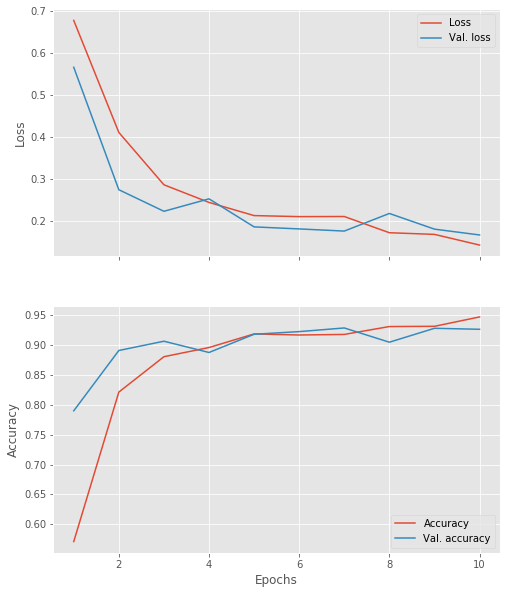

In [14]:
fig, axs = plt.subplots(2, 1, figsize=(8, 10), sharex=True)
axs = axs.ravel()
epochs = np.arange(1, n_epochs+1)
axs[0].plot(epochs, history.history['loss'], label='Loss')
axs[0].plot(epochs, history.history['val_loss'], label='Val. loss')
axs[1].plot(epochs, history.history['acc'], label='Accuracy')
axs[1].plot(epochs, history.history['val_acc'], label='Val. accuracy')
# labels
axs[1].set_xlabel("Epochs")
axs[0].set_ylabel("Loss")
axs[1].set_ylabel("Accuracy")
axs[0].legend()
axs[1].legend()
plt.show()

## Testing

Now the network is trained we can use the test set to further evaluate it's performance.

In [15]:
from sklearn import metrics

In [16]:
y_pred = model.predict(x_test)

In [17]:
fa, ta, _ = metrics.roc_curve(y_test[:,1], y_pred[:,1])

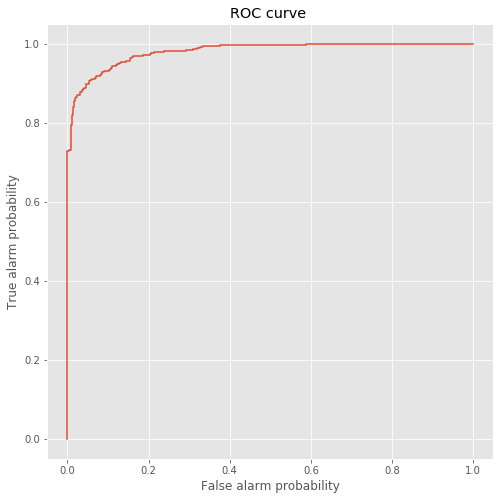

In [18]:
fig = plt.figure(figsize=(8,8))
plt.plot(fa, ta,)
plt.xlabel('False alarm probability')
plt.ylabel('True alarm probability')
plt.title('ROC curve ')
plt.show()